<a href="https://colab.research.google.com/github/Bugnico/Modelos1PruebasSaberPro/blob/main/02_preprocesamiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '.'
!kaggle
!chmod 600 ./kaggle.json


usage: kaggle [-h] [-v] [-W]
              {competitions,c,datasets,d,kernels,k,models,m,files,f,config}
              ...
kaggle: error: the following arguments are required: command


In [3]:
!kaggle competitions download -c udea-ai-4-eng-20251-pruebas-saber-pro-colombia

  0% 0.00/29.9M [00:00<?, ?B/s]
100% 29.9M/29.9M [00:00<00:00, 1.12GB/s]


In [4]:
!unzip udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip

Archive:  udea-ai-4-eng-20251-pruebas-saber-pro-colombia.zip
  inflating: submission_example.csv  
  inflating: test.csv                
  inflating: train.csv               


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
train = pd.read_csv('train.csv')

In [7]:
train.columns

Index(['ID', 'PERIODO', 'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO',
       'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE',
       'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD',
       'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR',
       'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL',
       'coef_1', 'coef_2', 'coef_3', 'coef_4'],
      dtype='object')

In [8]:
train.shape

(692500, 21)

In [9]:
train.info(False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692500 entries, 0 to 692499
Columns: 21 entries, ID to coef_4
dtypes: float64(4), int64(2), object(15)
memory usage: 111.0+ MB


In [10]:
train.isin([np.nan, np.inf, -np.inf]).sum()

,0
ID,0
PERIODO,0
ESTU_PRGM_ACADEMICO,0
ESTU_PRGM_DEPARTAMENTO,0
ESTU_VALORMATRICULAUNIVERSIDAD,6287
ESTU_HORASSEMANATRABAJA,30857
FAMI_ESTRATOVIVIENDA,32137
FAMI_TIENEINTERNET,26629
FAMI_EDUCACIONPADRE,23178
FAMI_TIENELAVADORA,39773


In [11]:

print(train['RENDIMIENTO_GLOBAL'].unique())


['medio-alto' 'bajo' 'alto' 'medio-bajo']


¿Qué significa los coef_ en mi dataset?


Alta correlación entre las variables.

Estadísticas descriptivas:
              coef_1         coef_2         coef_3         coef_4
count  692500.000000  692500.000000  692500.000000  692500.000000
mean        0.268629       0.259996       0.262087       0.262903
std         0.122130       0.093480       0.058862       0.067944
min         0.000000       0.000000       0.000000       0.000000
25%         0.203000       0.212000       0.254000       0.255000
50%         0.240000       0.271000       0.276000       0.285000
75%         0.314000       0.309000       0.293000       0.303000
max         0.657000       0.487000       0.320000       0.332000


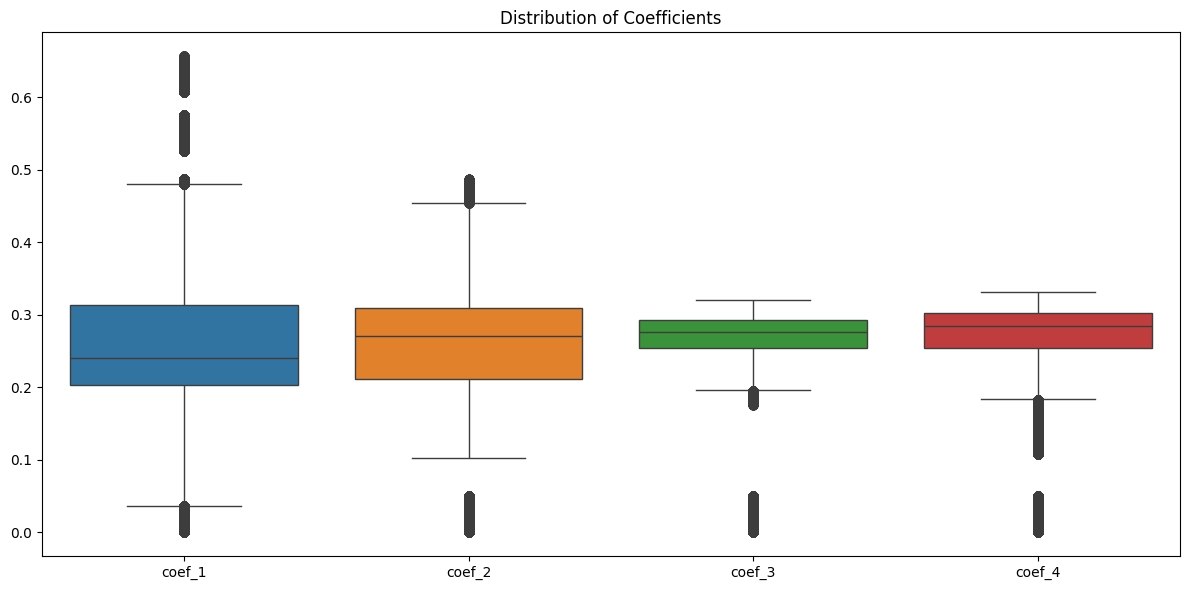

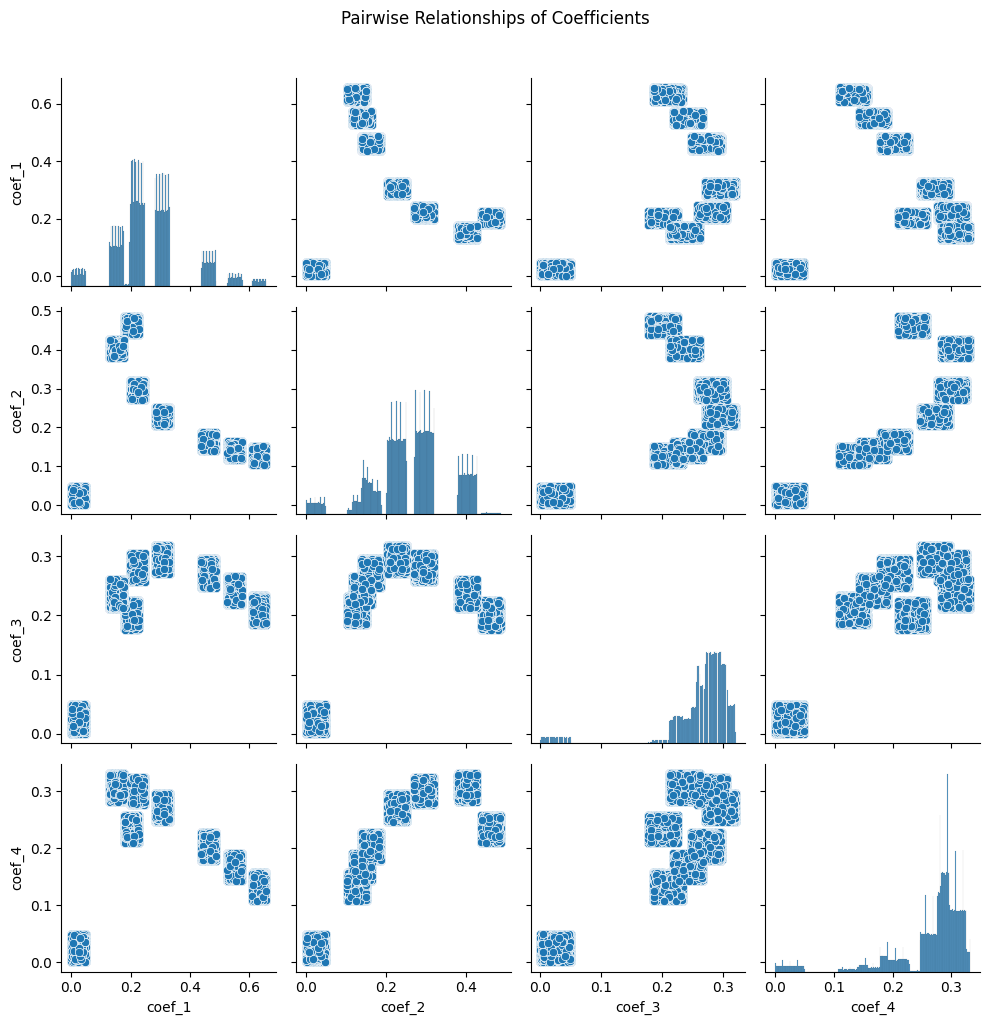

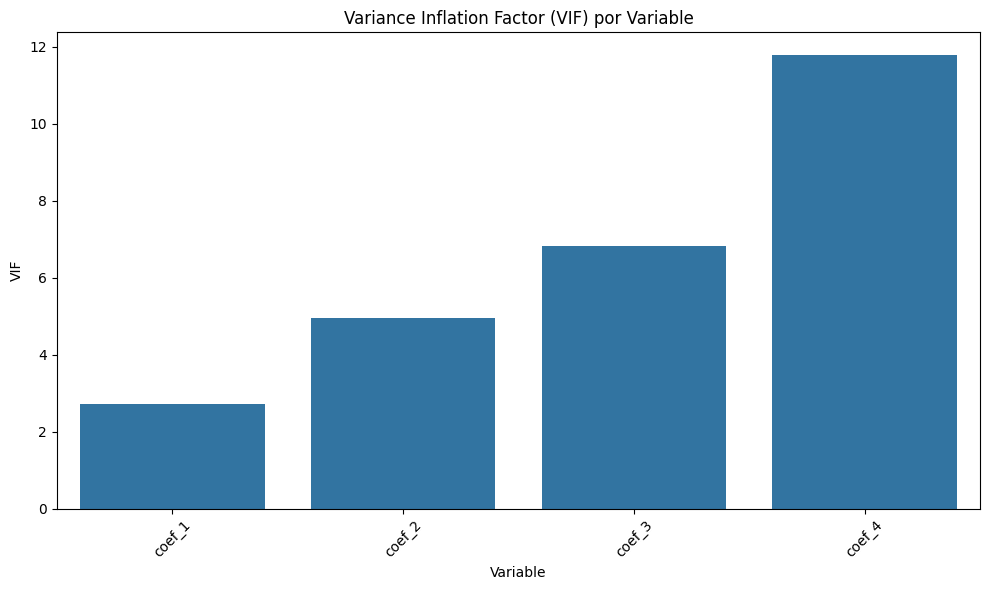

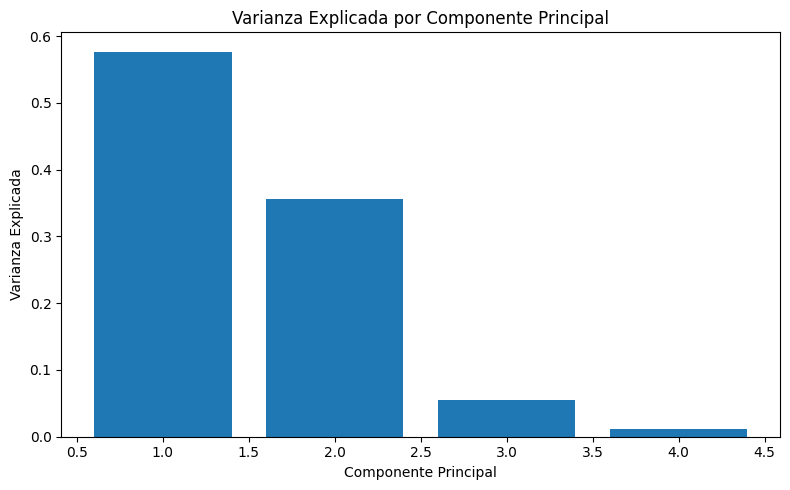

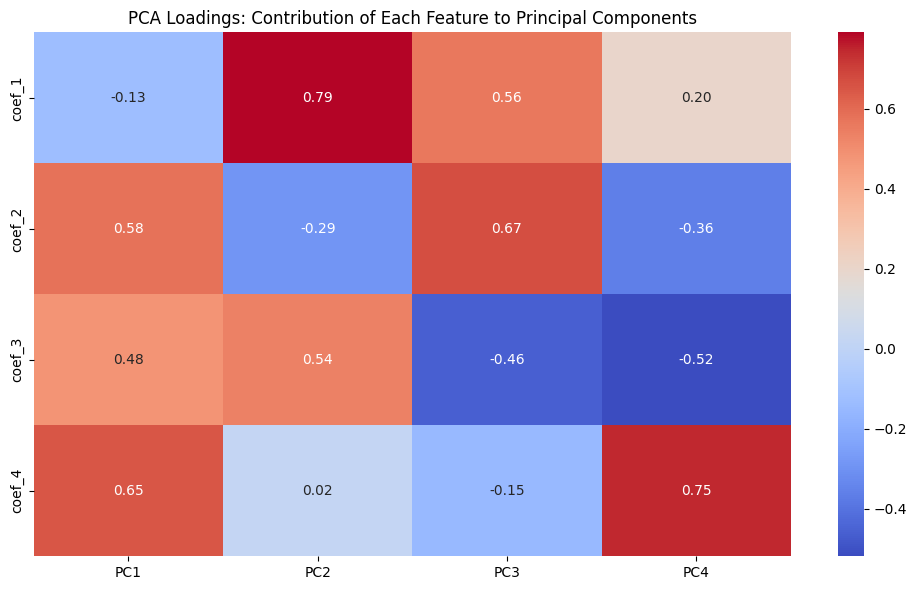

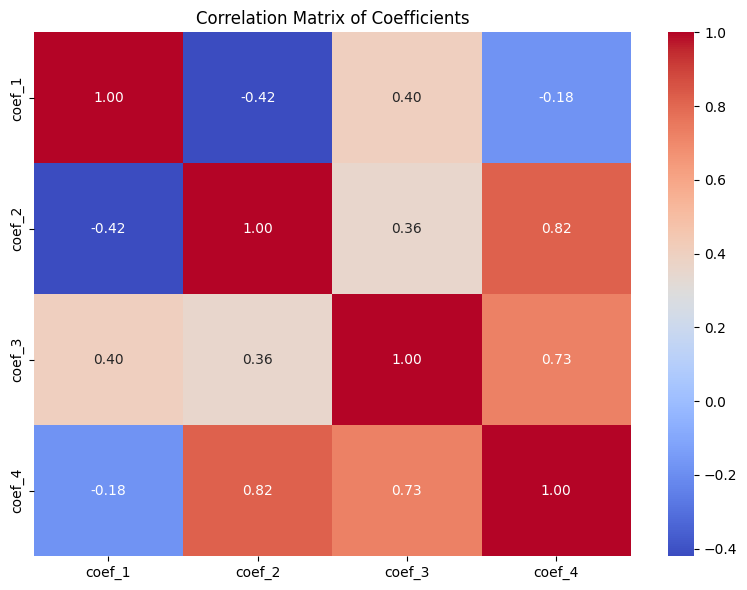


Matriz de correlación:
          coef_1    coef_2    coef_3    coef_4
coef_1  1.000000 -0.420428  0.401190 -0.179439
coef_2 -0.420428  1.000000  0.356097  0.821443
coef_3  0.401190  0.356097  1.000000  0.726692
coef_4 -0.179439  0.821443  0.726692  1.000000

Factores de inflación de varianza (VIF):
  Variable        VIF
0   coef_1   2.710113
1   coef_2   4.942846
2   coef_3   6.818327
3   coef_4  11.789607

Varianza explicada por los componentes principales:
[0.57666463 0.35595586 0.05524335 0.01213616]

Featuras a eliminar por alta correlación:
['coef_2']

Se han creado 3 componentes principales


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_regression

def load_and_preprocess(filepath, columns):
    df = pd.read_csv(filepath)
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def analyze_correlations(df, columns):
    correlation_matrix = df[columns].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Coefficients')
    plt.tight_layout()
    plt.show()
    return correlation_matrix

def calculate_vif(df, columns):
    X = df[columns].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    return vif_data

def apply_pca(df, columns, n_components=None):
    X = df[columns].dropna()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    column_names = [f'PC{i+1}' for i in range(principal_components.shape[1])]
    pc_df = pd.DataFrame(data=principal_components, columns=column_names)

    explained_variance = pca.explained_variance_ratio_
    loadings = pd.DataFrame(
        data=pca.components_.T,
        columns=column_names,
        index=columns
    )

    return pc_df, explained_variance, loadings, pca

def feature_selection_univariate(df, X_columns, y_column, k=3):
    X = df[X_columns].dropna()
    y = df[y_column].loc[X.index]

    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit_transform(X, y)

    scores = pd.DataFrame({
        'Feature': X_columns,
        'Score': selector.scores_
    }).sort_values(by='Score', ascending=False)

    selected_features = [X_columns[i] for i in selector.get_support(indices=True)]

    return scores, selected_features

def remove_lowest_importance(df, columns, correlation_threshold=0.8):
    corr_matrix = df[columns].corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = []
    for column in upper_tri.columns:
        if any(upper_tri[column] > correlation_threshold):
            correlated_vars = upper_tri.index[upper_tri[column] > correlation_threshold].tolist()
            avg_corr = []
            for var in correlated_vars + [column]:
                avg_corr.append(corr_matrix[var].mean())

            if avg_corr[-1] == max(avg_corr):
                to_drop.extend(correlated_vars)
            else:
                to_drop.append(column)

    to_drop = list(set(to_drop))
    return to_drop

def ridge_regression_cv(df, X_columns, y_column, alphas=np.logspace(-4, 4, 20)):
    from sklearn.linear_model import RidgeCV
    from sklearn.model_selection import KFold

    X = df[X_columns].dropna()
    y = df[y_column].loc[X.index]

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    ridge_cv = RidgeCV(alphas=alphas, cv=cv, scoring='neg_mean_squared_error')
    ridge_cv.fit(X, y)

    return ridge_cv

def lasso_feature_selection(df, X_columns, y_column, alphas=np.logspace(-4, 0, 50)):
    from sklearn.linear_model import LassoCV
    from sklearn.model_selection import KFold

    X = df[X_columns].dropna()
    y = df[y_column].loc[X.index]

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(alphas=alphas, cv=cv, max_iter=10000, random_state=42)
    lasso_cv.fit(X, y)

    feature_importance = pd.DataFrame({
        'Feature': X_columns,
        'Coefficient': lasso_cv.coef_
    })
    feature_importance = feature_importance.sort_values(by='Coefficient', key=abs, ascending=False)

    selected_features = feature_importance[feature_importance['Coefficient'] != 0]['Feature'].tolist()

    return lasso_cv, feature_importance, selected_features

def evaluate_multicollinearity(df, columns):
    results = {}

    correlation_matrix = analyze_correlations(df, columns)
    results['correlation_matrix'] = correlation_matrix

    vif_data = calculate_vif(df, columns)
    results['vif_data'] = vif_data

    pc_df, explained_variance, loadings, pca = apply_pca(df, columns)
    results['pca_variance'] = explained_variance
    results['pca_loadings'] = loadings
    results['pca_model'] = pca

    to_drop = remove_lowest_importance(df, columns)
    results['features_to_drop'] = to_drop
    results['features_to_keep'] = [col for col in columns if col not in to_drop]

    return results

def visualize_multicollinearity(df, columns):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[columns])
    plt.title('Distribution of Coefficients')
    plt.tight_layout()
    plt.show()

    sns.pairplot(df[columns])
    plt.suptitle('Pairwise Relationships of Coefficients', y=1.02)
    plt.tight_layout()
    plt.show()

    vif_data = calculate_vif(df, columns)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Variable', y='VIF', data=vif_data)
    plt.title('Variance Inflation Factor (VIF) por Variable')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    pc_df, explained_variance, loadings, pca = apply_pca(df, columns)
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance)
    plt.xlabel('Componente Principal')
    plt.ylabel('Varianza Explicada')
    plt.title('Varianza Explicada por Componente Principal')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(loadings, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('PCA Loadings: Contribution of Each Feature to Principal Components')
    plt.tight_layout()
    plt.show()

def process_multicollinearity(df, columns, y_column=None, method='pca', target_variance=0.95):
    if method == 'pca':
        X = df[columns].dropna()
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA(n_components=target_variance)
        principal_components = pca.fit_transform(X_scaled)

        column_names = [f'PC{i+1}' for i in range(principal_components.shape[1])]
        pc_df = pd.DataFrame(data=principal_components, columns=column_names, index=X.index)

        result_df = df.copy()
        for col in column_names:
            result_df.loc[pc_df.index, col] = pc_df[col]

        return result_df, pca

    elif method == 'vif_elimination':
        threshold = 10
        current_columns = columns.copy()
        result_df = df.copy()

        while True:
            vif_data = calculate_vif(result_df, current_columns)
            max_vif = vif_data['VIF'].max()

            if max_vif < threshold:
                break

            max_vif_feature = vif_data.loc[vif_data['VIF'] == max_vif, 'Variable'].values[0]
            current_columns.remove(max_vif_feature)

        return result_df[current_columns], current_columns

    elif method == 'feature_selection' and y_column:
        scores, selected_features = feature_selection_univariate(df, columns, y_column)
        return df[selected_features], selected_features

    elif method == 'lasso' and y_column:
        lasso_cv, feature_importance, selected_features = lasso_feature_selection(df, columns, y_column)
        return df[selected_features], selected_features

    elif method == 'correlation':
        to_drop = remove_lowest_importance(df, columns)
        keep_columns = [col for col in columns if col not in to_drop]
        return df[keep_columns], keep_columns

    else:
        return df[columns], columns

# Función principal que integra todos los pasos
def handle_multicollinearity(filepath, columns, y_column=None, method='pca'):
    df = load_and_preprocess(filepath, columns)

    print("Estadísticas descriptivas:")
    print(df[columns].describe())

    visualize_multicollinearity(df, columns)

    analysis_results = evaluate_multicollinearity(df, columns)

    print("\nMatriz de correlación:")
    print(analysis_results['correlation_matrix'])

    print("\nFactores de inflación de varianza (VIF):")
    print(analysis_results['vif_data'])

    print("\nVarianza explicada por los componentes principales:")
    print(analysis_results['pca_variance'])

    print("\nFeaturas a eliminar por alta correlación:")
    print(analysis_results['features_to_drop'])

    processed_df, result = process_multicollinearity(df, columns, y_column, method)

    if method == 'pca':
        print(f"\nSe han creado {len(processed_df.filter(like='PC').columns)} componentes principales")
    else:
        print(f"\nFeatures seleccionadas: {result}")

    return processed_df, analysis_results, result

# Ejemplo de uso
if __name__ == "__main__":
    filepath = 'train.csv'
    columns_to_compare = ['coef_1', 'coef_2', 'coef_3', 'coef_4']

    # Para un problema de regresión donde queremos predecir 'target_column'
    processed_df, analysis, result = handle_multicollinearity(
        filepath,
        columns_to_compare,
        y_column='target_column',  # Reemplazar con el nombre real de la columna objetivo
        method='pca'  # Opciones: 'pca', 'vif_elimination', 'feature_selection', 'lasso', 'correlation'
    )

In [13]:
def codificar_rendimiento_global_mejorado(df, column_name='RENDIMIENTO_GLOBAL'):
    """
    Codifica la columna RENDIMIENTO_GLOBAL con valores numéricos
    según una escala ordinal personalizada, con visualización optimizada.
    """
    # Definimos el mapeo personalizado según el orden natural
    mapping = {
        'bajo': 0.1,       # El nivel más bajo
        'medio-bajo': 0.33, # Entre bajo y medio
        'medio-alto': 0.67, # Entre medio y alto
        'alto': 1.0        # El nivel más alto
    }

    # Creamos una copia del dataframe para no modificar el original


    # Aplicamos el mapeo para crear la nueva columna
    train['RENDIMIENTO_GLOBAL_NUM'] = df[column_name].map(mapping)

    # Verificamos que no haya valores nulos tras el mapeo
    missing = train.loc[train['RENDIMIENTO_GLOBAL_NUM'].isna(), column_name].unique()
    if len(missing) > 0:
        print(f"¡Advertencia! Los siguientes valores no se pudieron mapear: {missing}")

    # Mostramos el mapeo realizado
    print("Mapeo de RENDIMIENTO_GLOBAL a valores numéricos:")
    for categoria, valor in mapping.items():
        print(f"  {categoria} -> {valor}")

    # Obtenemos las cuentas para normalizar los tamaños
    counts = df[column_name].value_counts()
    max_count = counts.max()

    return train, mapping

In [14]:
codificar_rendimiento_global_mejorado(train)

Mapeo de RENDIMIENTO_GLOBAL a valores numéricos:
  bajo -> 0.1
  medio-bajo -> 0.33
  medio-alto -> 0.67
  alto -> 1.0


(            ID  PERIODO                  ESTU_PRGM_ACADEMICO  \
 0       904256    20212                           ENFERMERIA   
 1       645256    20212                              DERECHO   
 2       308367    20203                MERCADEO Y PUBLICIDAD   
 3       470353    20195           ADMINISTRACION DE EMPRESAS   
 4       989032    20212                           PSICOLOGIA   
 ...        ...      ...                                  ...   
 692495   25096    20195                             BIOLOGIA   
 692496  754213    20212                           PSICOLOGIA   
 692497  504185    20183  ADMINISTRACIÓN EN SALUD OCUPACIONAL   
 692498  986620    20195                           PSICOLOGIA   
 692499  933374    20195                           PSICOLOGIA   
 
        ESTU_PRGM_DEPARTAMENTO            ESTU_VALORMATRICULAUNIVERSIDAD  \
 0                      BOGOTÁ  Entre 5.5 millones y menos de 7 millones   
 1                   ATLANTICO  Entre 2.5 millones y menos de 4 mi

# Preprocesado de datos - Entrega #2.

Inicialmente voy a categorizar las variables más sencillas según la lógica respectiva, variables que solo tienen valores binarios, es decir 'Si' & 'No' por los numeros 1 = 'Si' y 0 = 'No'

Las columnas que nos permiten hacer esto son las siguientes: 'FAMI_TIENEINTERNET' , 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR'

In [15]:
target_columns = ['FAMI_TIENEINTERNET' , 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR']

mapeo = {'Si': 1, 'S': 1, 'No': 0, 'N':0}


In [16]:
for column in target_columns:
    train[column] = train[column].map(mapeo)


# Calcula el recuento de valores faltantes en las columnas específicas
valores_faltantes = train[target_columns].isnull().sum()
print(valores_faltantes)

FAMI_TIENEINTERNET          26629
FAMI_TIENELAVADORA          39773
FAMI_TIENEAUTOMOVIL         43623
ESTU_PRIVADO_LIBERTAD           0
ESTU_PAGOMATRICULAPROPIO     6498
FAMI_TIENECOMPUTADOR        38103
dtype: int64


En este caso vamos a imputar los datos de la forma más sencilla posible, en este caso daremos sentido de que los datos faltante son NO como si no tuviera. NO = 0

In [17]:

for column in target_columns:
    train[column] = train[column].fillna(0)

# Verifica nuevamente los valores faltantes para confirmar
valores_faltantes_despues = train[target_columns].isnull().sum()
print("\nValores faltantes después de la imputación:")
valores_faltantes_despues



Valores faltantes después de la imputación:


,0
FAMI_TIENEINTERNET,0
FAMI_TIENELAVADORA,0
FAMI_TIENEAUTOMOVIL,0
ESTU_PRIVADO_LIBERTAD,0
ESTU_PAGOMATRICULAPROPIO,0
FAMI_TIENECOMPUTADOR,0


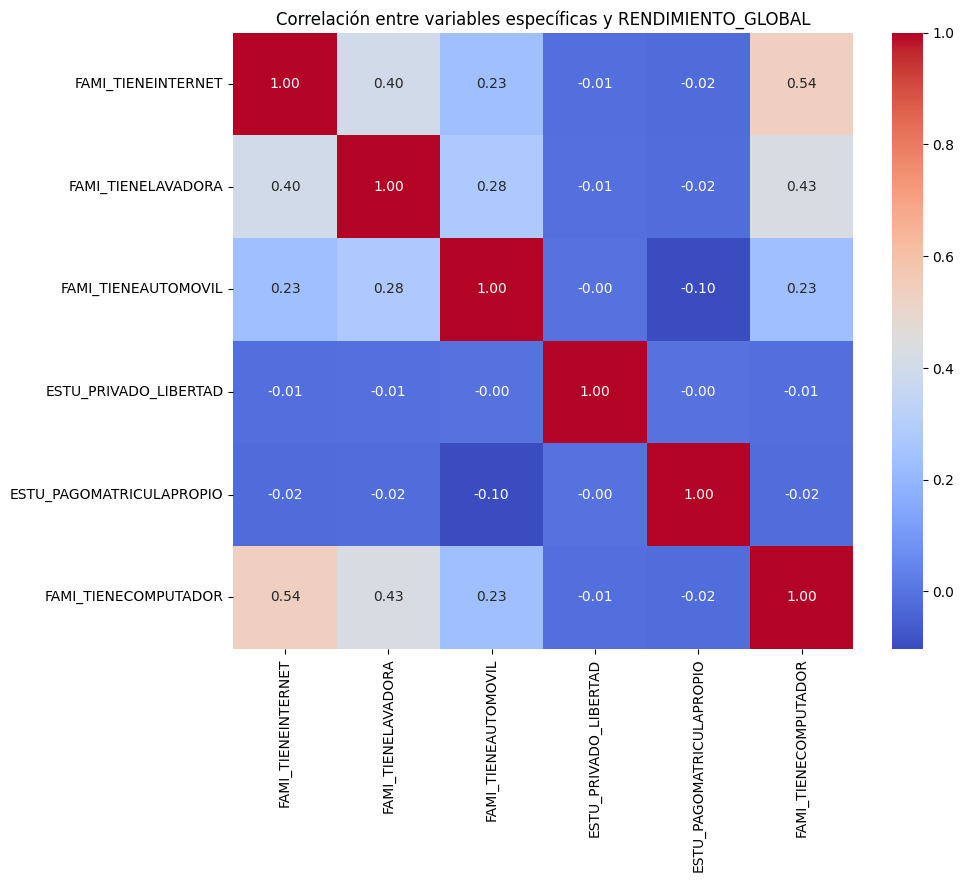

In [18]:

# Calcular la matriz de correlación solo para estas columnas
correlation_matrix_specific = train[target_columns].corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_specific, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre variables específicas y RENDIMIENTO_GLOBAL')
plt.show()





Ahora vamos a identificar otra columna que tiene valores categoricos es decir son valores que puede tener un orden logico, en este caso identificamos las siguientes columnas que cumplen con lo que buscamos: ['FAMI_ESTRATOVIVIENDA'] Vamos a inspeccionar esta columnas para saber que posibles valores tienen

In [19]:

c="FAMI_ESTRATOVIVIENDA"
train[c].value_counts()

,count
FAMI_ESTRATOVIVIENDA,
Estrato 2,232671
Estrato 3,210685
Estrato 1,111991
Estrato 4,65514
Estrato 5,23608
Estrato 6,12605
Sin Estrato,3289


In [20]:
# Diccionario de mapeo para FAMI_ESTRATOVIVIENDA
mapeo_estrato = {'Sin Estrato': 0, 'Estrato 1': 1, 'Estrato 2': 2, 'Estrato 3': 3, 'Estrato 4': 4, 'Estrato 5': 5, 'Estrato 6': 6}


# Aplicar mapeo a las columnas respectivas
train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].map(mapeo_estrato)


valores_faltantes_estrato = train['FAMI_ESTRATOVIVIENDA'].isnull().sum()
# Muestra los valores faltantes
print("Valores faltantes en FAMI_ESTRATOVIVIENDA:", valores_faltantes_estrato)


Valores faltantes en FAMI_ESTRATOVIVIENDA: 32137


Una estrategía interesante sería usar la media de los datos, ya que no es muy considerable la cantidad de datos vacios.

In [21]:
# Imputar los valores faltantes con la media
train['FAMI_ESTRATOVIVIENDA'] = train['FAMI_ESTRATOVIVIENDA'].fillna(train['FAMI_ESTRATOVIVIENDA'].median())



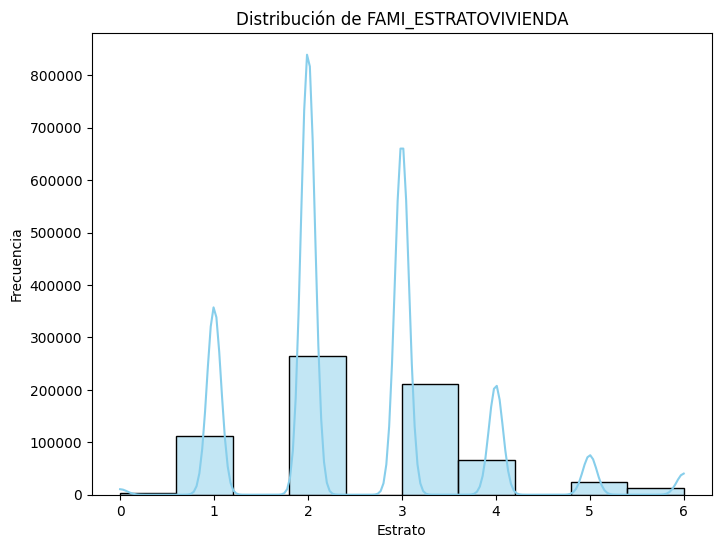

In [22]:
plt.figure(figsize=(8, 6))
sns.histplot(train['FAMI_ESTRATOVIVIENDA'], bins=10, kde=True, color='skyblue')
plt.title('Distribución de FAMI_ESTRATOVIVIENDA')
plt.xlabel('Estrato')
plt.ylabel('Frecuencia')
plt.show()


Bien hasta este punto vale la pena hacer una recuento de lo que hemos hecho en este colab, hasta este punto hemos hecho lo siguiente:

*   Transformamos la columna a predecir en valores números
* Transformamos las columnas que tenian solamente 'No' y 'Si'
* Transformamos una columna categorica





---



Ahora es necesario tratar las columnas con variables continuas, es decir: las columnas que expresan los valores en cierto rango. En este caso las columnas que vamos a tratar serian: ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

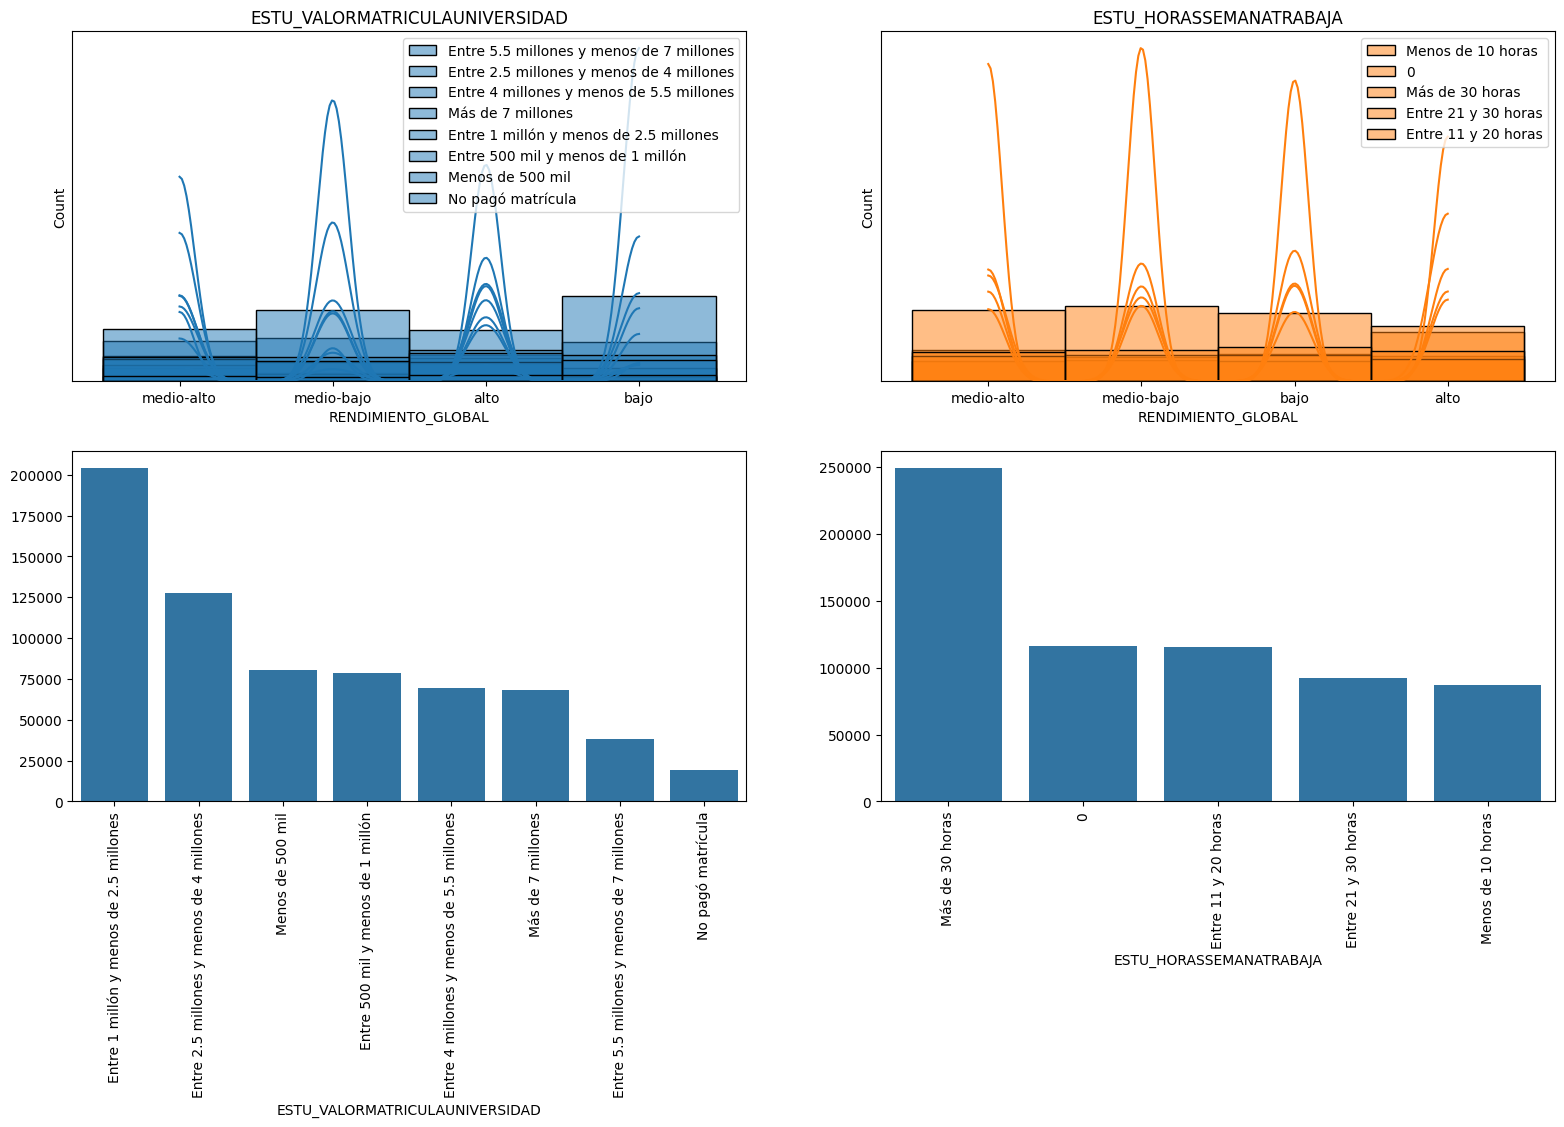

In [23]:
plt.figure(figsize=(40,10))
for i, c in enumerate(["ESTU_VALORMATRICULAUNIVERSIDAD", "ESTU_HORASSEMANATRABAJA"]):
    plt.subplot(2,4,i+1)
    k = train[[c,"RENDIMIENTO_GLOBAL"]].dropna()
    for v in train[c].dropna().unique():
        sns.histplot(k.RENDIMIENTO_GLOBAL[k[c]==v], label=v, kde=True, color=sns.color_palette()[i])
        plt.title(c)
    plt.yticks([])
    plt.legend()
    plt.subplot(2,4,i+5)
    vc = k[c].value_counts()
    sns.barplot(x=vc.index, y=vc.values)
    plt.xticks(rotation="vertical")


Con estas gráficas podemos darnos cuenta de cosas muy interesantes, entre ellas estan.

Hay mayor cantidad de estudiantes que pagan entre 1 y 2.5 millones en su matricula al igual que hay una gran cantidad de estudiantes que trabajan más de 30 horas
Se ve que los estudiantes que pagan más de 7 millones son más propensos a sacar un nivel alto en la prueba

In [24]:
continue_variables = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA']

# Definir el mapeo de categorías a valores numéricos para cada columna
mapeo_valores_matricula = {
    'Menos de 500 mil': 0,
    'Entre 500 mil y menos de 1 millón': 1,
    'Entre 1 millón y menos de 2.5 millones': 2,
    'Entre 2.5 millones y menos de 4 millones': 3,
    'Entre 4 millones y menos de 5.5 millones': 4,
    'Entre 5.5 millones y menos de 7 millones': 5,
    'Más de 7 millones': 6,
    'No pagó matrícula': 7
}

mapeo_valores_horas_trabajo = {
    '0': 0,
    'Menos de 10 horas': 1,
    'Entre 11 y 20 horas': 2,
    'Entre 21 y 30 horas': 3,
    'Más de 30 horas': 4
}

# Convertir las columnas a formato numérico utilizando el mapeo
train['ESTU_VALORMATRICULAUNIVERSIDAD'] = train['ESTU_VALORMATRICULAUNIVERSIDAD'].map(mapeo_valores_matricula)
train['ESTU_HORASSEMANATRABAJA'] = train['ESTU_HORASSEMANATRABAJA'].map(mapeo_valores_horas_trabajo)

# Verificar los cambios
print(train[['ESTU_VALORMATRICULAUNIVERSIDAD','ESTU_HORASSEMANATRABAJA']].head())



   ESTU_VALORMATRICULAUNIVERSIDAD  ESTU_HORASSEMANATRABAJA
0                             5.0                      1.0
1                             3.0                      0.0
2                             3.0                      4.0
3                             4.0                      0.0
4                             3.0                      3.0


In [25]:
# Para rellenar los valores faltantes de 'continue_variables' con valores aleatorios dentro del rango observado
for col in continue_variables:
  # Obtener los valores únicos no nulos de la columna
  observed_values = train[col].dropna().unique()
  # Para cada valor nulo en la columna
  null_indices = train[train[col].isnull()].index
  if len(null_indices) > 0:
    # Seleccionar aleatoriamente valores de los valores observados
    random_fill_values = np.random.choice(observed_values, size=len(null_indices))
    # Asignar los valores aleatorios a las posiciones nulas
    train.loc[null_indices, col] = random_fill_values

# Verificar si aún quedan valores faltantes en esas columnas
print("\nValores faltantes después de la imputación con valores aleatorios:")
print(train[continue_variables].isnull().sum())


Valores faltantes después de la imputación con valores aleatorios:
ESTU_VALORMATRICULAUNIVERSIDAD    0
ESTU_HORASSEMANATRABAJA           0
dtype: int64


In [26]:

valores_faltantes = train.isnull().sum()

# Muestra los valores faltantes
print(valores_faltantes)


ID                                    0
PERIODO                               0
ESTU_PRGM_ACADEMICO                   0
ESTU_PRGM_DEPARTAMENTO                0
ESTU_VALORMATRICULAUNIVERSIDAD        0
ESTU_HORASSEMANATRABAJA               0
FAMI_ESTRATOVIVIENDA                  0
FAMI_TIENEINTERNET                    0
FAMI_EDUCACIONPADRE               23178
FAMI_TIENELAVADORA                    0
FAMI_TIENEAUTOMOVIL                   0
ESTU_PRIVADO_LIBERTAD                 0
ESTU_PAGOMATRICULAPROPIO              0
FAMI_TIENECOMPUTADOR                  0
FAMI_TIENEINTERNET.1              26629
FAMI_EDUCACIONMADRE               23664
RENDIMIENTO_GLOBAL                    0
coef_1                                0
coef_2                                0
coef_3                                0
coef_4                                0
RENDIMIENTO_GLOBAL_NUM                0
dtype: int64


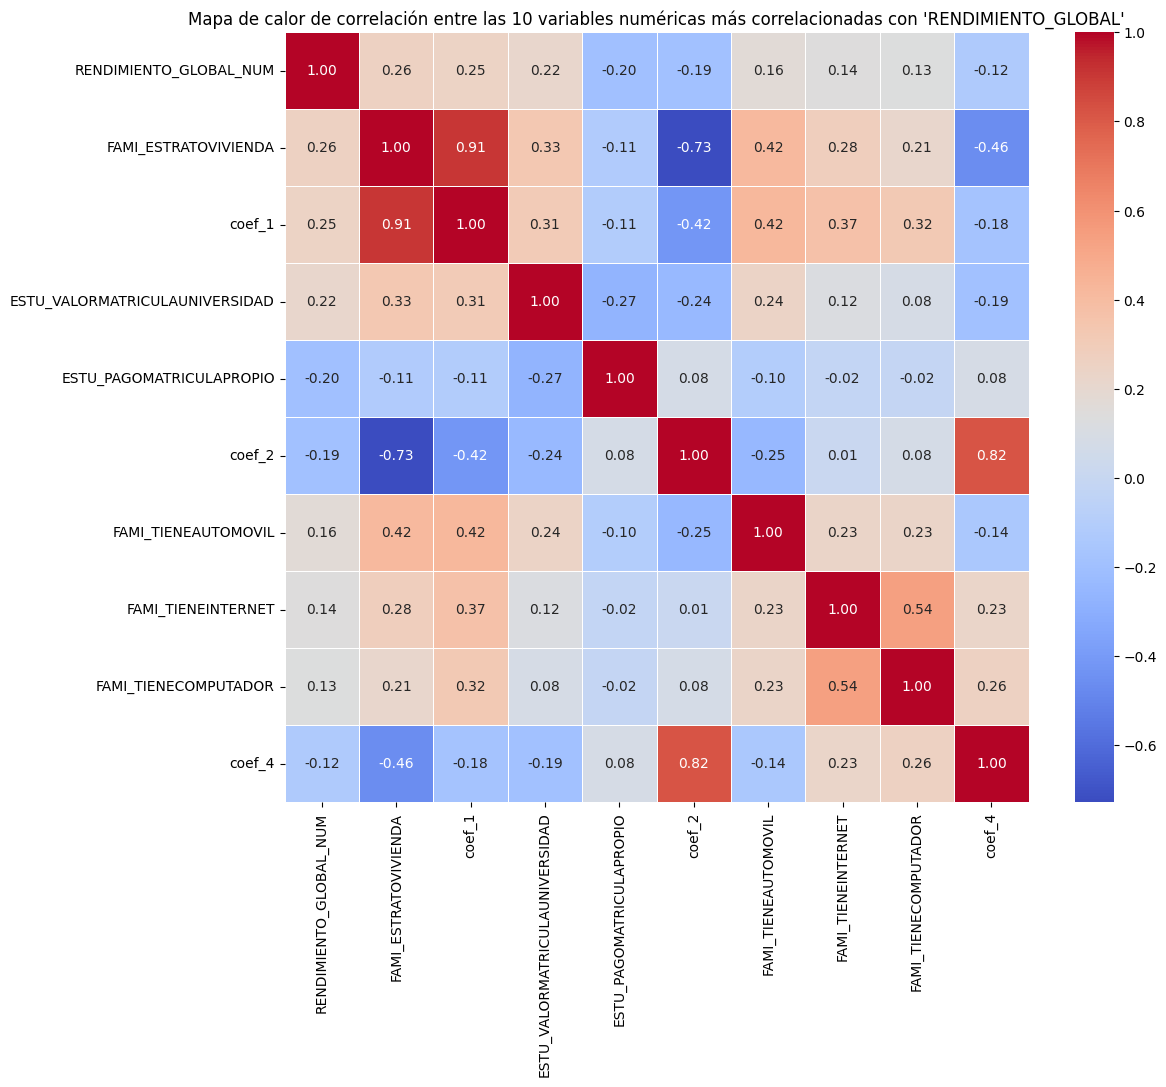

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seleccionar solo las columnas numéricas del DataFrame
numeric_cols = train.select_dtypes(include=['int', 'float']).columns

# Calcular la matriz de correlación entre las variables numéricas y la variable objetivo
correlation_matrix = train[numeric_cols].corrwith(train['RENDIMIENTO_GLOBAL_NUM'])

# Ordenar las correlaciones en valor absoluto
correlation_matrix_abs = correlation_matrix.abs().sort_values(ascending=False)

# Seleccionar las 10 variables con mayor correlación (positiva o negativa) con la variable objetivo
top_correlated_features = correlation_matrix_abs.head(10)

# Seleccionar las variables correspondientes de la matriz de correlación
top_correlation_matrix = train[top_correlated_features.index].corr()

# Crear el mapa de calor de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(top_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Mapa de calor de correlación entre las 10 variables numéricas más correlacionadas con 'RENDIMIENTO_GLOBAL'")
plt.show()


Y bien despues de hacer la respectiva limpieza de datos, usando diferentes metodos para rellenar datos faltantes, y transformar las diferentes columnas en valores numericos con los que podamos trabajar es hora de plantear una alternativa para la columnas 'FAMI_EDUCACIONPADRE' & FAMI_EDUCACIONMADRE ya que estás representan las únicas columnas con valores faltantes que nos quedaron, ahora no podemos usar el mismo enfoque anterior puesto que a diferencias de estas, no hay forma de clasificar todas las opciones en un orden de jerarquía además si observamos más a detalle, hay valores que significan lo mismo o parcialmente lo mismo como lo pueden ser ['Educación profesional completa' 'Educación profesional incompleta' 'Ninguno' 'No Aplica' 'No sabe'] por lo tanto una alternativa a estas columnas es la estrategia de "one-hot "

Primero rellenemos los datos faltantes con está vez la moda de las columnas.



In [28]:
mode_padre = train['FAMI_EDUCACIONPADRE'].mode()[0]
mode_madre = train['FAMI_EDUCACIONMADRE'].mode()[0]

# Fill the missing values with the calculated modes
train['FAMI_EDUCACIONPADRE'] = train['FAMI_EDUCACIONPADRE'].fillna(mode_padre)
train['FAMI_EDUCACIONMADRE'] = train['FAMI_EDUCACIONMADRE'].fillna(mode_madre)

# Verify the changes
print("\nValores faltantes después de imputar con la moda:")
print(train[['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE']].isnull().sum())


Valores faltantes después de imputar con la moda:
FAMI_EDUCACIONPADRE    0
FAMI_EDUCACIONMADRE    0
dtype: int64


In [29]:
import pandas as pd

# Aplicar one-hot encoding a las columnas 'FAMI_EDUCACIONPADRE' y 'FAMI_EDUCACIONMADRE'
train = pd.get_dummies(train, columns=['FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE'], prefix=['PADRE_EDUCACION', 'MADRE_EDUCACION'])

# Mostrar las primeras filas del DataFrame resultante
print(train.head())

# Asignar 0 para False y 1 para True en las columnas generadas por one-hot encoding
train.replace({True: 1, False: 0}, inplace=True)

# Verificar los cambios
print(train.head(10))


       ID  PERIODO         ESTU_PRGM_ACADEMICO ESTU_PRGM_DEPARTAMENTO  \
0  904256    20212                  ENFERMERIA                 BOGOTÁ   
1  645256    20212                     DERECHO              ATLANTICO   
2  308367    20203       MERCADEO Y PUBLICIDAD                 BOGOTÁ   
3  470353    20195  ADMINISTRACION DE EMPRESAS              SANTANDER   
4  989032    20212                  PSICOLOGIA              ANTIOQUIA   

   ESTU_VALORMATRICULAUNIVERSIDAD  ESTU_HORASSEMANATRABAJA  \
0                             5.0                      1.0   
1                             3.0                      0.0   
2                             3.0                      4.0   
3                             4.0                      0.0   
4                             3.0                      3.0   

   FAMI_ESTRATOVIVIENDA  FAMI_TIENEINTERNET  FAMI_TIENELAVADORA  \
0                   3.0                 1.0                 1.0   
1                   3.0                 0.0           

<ipython-input-29-fd62b5185a48>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train.replace({True: 1, False: 0}, inplace=True)


       ID  PERIODO                  ESTU_PRGM_ACADEMICO  \
0  904256    20212                           ENFERMERIA   
1  645256    20212                              DERECHO   
2  308367    20203                MERCADEO Y PUBLICIDAD   
3  470353    20195           ADMINISTRACION DE EMPRESAS   
4  989032    20212                           PSICOLOGIA   
5  659872    20203                 MEDICINA VETERINARIA   
6   47159    20183                  INGENIERIA MECANICA   
7   11829    20183  ADMINISTRACIÓN EN SALUD OCUPACIONAL   
8  257869    20212                INGENIERIA INDUSTRIAL   
9  465511    20183           ADMINISTRACION DE EMPRESAS   

  ESTU_PRGM_DEPARTAMENTO  ESTU_VALORMATRICULAUNIVERSIDAD  \
0                 BOGOTÁ                             5.0   
1              ATLANTICO                             3.0   
2                 BOGOTÁ                             3.0   
3              SANTANDER                             4.0   
4              ANTIOQUIA                          

In [30]:
# Columnas que deben convertirse a enteros
columnas_float_a_entero = ['ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA',
                           'FAMI_TIENEINTERNET', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL',
                           'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR']

# Convertir las columnas de float a enteros
train[columnas_float_a_entero] = train[columnas_float_a_entero].astype(int)

# Verificar los cambios
print(train.dtypes)


ID                                                        int64
PERIODO                                                   int64
ESTU_PRGM_ACADEMICO                                      object
ESTU_PRGM_DEPARTAMENTO                                   object
ESTU_VALORMATRICULAUNIVERSIDAD                            int64
ESTU_HORASSEMANATRABAJA                                   int64
FAMI_ESTRATOVIVIENDA                                    float64
FAMI_TIENEINTERNET                                        int64
FAMI_TIENELAVADORA                                        int64
FAMI_TIENEAUTOMOVIL                                       int64
ESTU_PRIVADO_LIBERTAD                                     int64
ESTU_PAGOMATRICULAPROPIO                                  int64
FAMI_TIENECOMPUTADOR                                      int64
FAMI_TIENEINTERNET.1                                     object
RENDIMIENTO_GLOBAL                                       object
coef_1                                  

Ahora tenemos la necesidad de trabajar las 2 columnas que más peso tienen en nuestro modelo, y estamos hablando de [ESTU_PRGM_ACADEMICO, ESTU_PRGM_DEPARTAMENTO]

¿Qué estrategía usaremos ?

la columna 'ESTU_PRGM_DEPARTAMENTO' la repartiremos por Regiones de colombia y despues realizaremos one-hot con ellas


In [31]:
# Definir las regiones y los departamentos correspondientes
departamentos_por_region = {
    'Region Caribe': ['ATLANTICO', 'BOLIVAR', 'CORDOBA', 'CESAR' 'LA GUAJIRA', 'MAGDALENA', 'SUCRE', 'SAN ANDRES'],
    'Region Andina': ['ANTIOQUIA', 'BOYACA', 'CUNDINAMARCA', 'RISARALDA', 'TOLIMA', 'CALDAS', 'CAUCA', 'HUILA', 'NORTE SANTANDER', 'QUINDIO', 'SANTANDER', 'BOGOTA'],
    'Region Pacifica': ['CHOCO', 'NARIÑO', 'VALLE'],
    'Region Orinoquia': ['ARAUCA', 'CASANARE', 'META'],
    'Region Amazonica': ['AMAZONAS', 'CAQUETA', 'GUAVIARE', 'VAUPES', 'PUTUMAYO'],
}
# Prefijo para los nombres de las nuevas columnas
prefijo_columnas = 'DEPARTAMENTO_'

# Crear columnas para cada región y asignar los departamentos correspondientes
for region, departamentos in departamentos_por_region.items():
    train[prefijo_columnas + region.replace(' ', '_').upper()] = train['ESTU_PRGM_DEPARTAMENTO'].apply(lambda x: x if x in departamentos else None)

# Eliminar la columna original ESTU_PRGM_DEPARTAMENTO
train.drop(columns=['ESTU_PRGM_DEPARTAMENTO'], inplace=True)

# Crear el mapeo para cada región
map_recurrencia_caribe = {'SAN ANDRES': 1, 'LA GUAJIRA': 2, 'CESAR': 3, 'SUCRE': 4, 'MAGDALENA': 5, 'CORDOBA': 6, 'BOLIVAR': 7, 'NORTE SANTANDER': 8, 'ATLANTICO': 9}
map_recurrencia_andina = {'QUINDIO': 1, 'HUILA': 2, 'CAUCA': 3, 'CALDAS': 4, 'TOLIMA': 5, 'RISARALDA': 6, 'CUNDINAMARCA': 7, 'BOYACA': 8, 'SANTANDER': 9, 'ANTIOQUIA': 10, 'BOGOTA': 11}
map_recurrencia_pacifica = {'CHOCO': 1, 'NARIÑO': 2, 'VALLE': 3}
map_recurrencia_orinoquia = {'ARAUCA': 1, 'CASANARE': 2, 'META': 3}
map_recurrencia_amazonica = {'VAUPES': 1, 'GUAVIARE': 2, 'AMAZONAS': 3, 'PUTUMAYO': 4, 'CAQUETA': 5}


train['DEPARTAMENTO_REGION_CARIBE'] = train['DEPARTAMENTO_REGION_CARIBE'].map(map_recurrencia_caribe)
train['DEPARTAMENTO_REGION_ANDINA'] = train['DEPARTAMENTO_REGION_ANDINA'].map(map_recurrencia_andina)
train['DEPARTAMENTO_REGION_PACIFICA'] = train['DEPARTAMENTO_REGION_PACIFICA'].map(map_recurrencia_pacifica)
train['DEPARTAMENTO_REGION_ORINOQUIA'] = train['DEPARTAMENTO_REGION_ORINOQUIA'].map(map_recurrencia_orinoquia)
train['DEPARTAMENTO_REGION_AMAZONICA'] = train['DEPARTAMENTO_REGION_AMAZONICA'].map(map_recurrencia_amazonica)

# Finalización de la parte 2

Ya hemos realizado la inputación de datos faltantes, analisis de cómo influyen con respecto a mi variable a predecir, pero aun nos queda 1 columna por inspeccionar...

ESTU_PRGM_ACADEMICO                                      object

Lo que sucede con esta columna es que tienen muchos valores distintos, esto puede generar incovenientes a la hora de especificar una estrategia de inputación lo que haremos es buscar alguna forma de agrupar los valores y despúes trabajar con ellos en la próxima entrega para poder validar algún modelo.

In [33]:

train.fillna(0, inplace=True)

In [34]:
train.head(10)

,ID,PERIODO,ESTU_PRGM_ACADEMICO,ESTU_VALORMATRICULAUNIVERSIDAD,ESTU_HORASSEMANATRABAJA,FAMI_ESTRATOVIVIENDA,FAMI_TIENEINTERNET,FAMI_TIENELAVADORA,FAMI_TIENEAUTOMOVIL,ESTU_PRIVADO_LIBERTAD,...,MADRE_EDUCACION_Primaria incompleta,MADRE_EDUCACION_Secundaria (Bachillerato) completa,MADRE_EDUCACION_Secundaria (Bachillerato) incompleta,MADRE_EDUCACION_Técnica o tecnológica completa,MADRE_EDUCACION_Técnica o tecnológica incompleta,DEPARTAMENTO_REGION_CARIBE,DEPARTAMENTO_REGION_ANDINA,DEPARTAMENTO_REGION_PACIFICA,DEPARTAMENTO_REGION_ORINOQUIA,DEPARTAMENTO_REGION_AMAZONICA
0,904256,20212,ENFERMERIA,5,1,3.0,1,1,1,0,...,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,645256,20212,DERECHO,3,0,3.0,0,1,0,0,...,0,0,0,0,1,9.0,0.0,0.0,0.0,0.0
2,308367,20203,MERCADEO Y PUBLICIDAD,3,4,3.0,1,1,0,0,...,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0
3,470353,20195,ADMINISTRACION DE EMPRESAS,4,0,4.0,1,1,0,0,...,0,1,0,0,0,0.0,9.0,0.0,0.0,0.0
4,989032,20212,PSICOLOGIA,3,3,3.0,1,1,1,0,...,0,0,0,0,0,0.0,10.0,0.0,0.0,0.0
5,659872,20203,MEDICINA VETERINARIA,6,1,5.0,1,1,1,0,...,0,1,0,0,0,0.0,10.0,0.0,0.0,0.0
6,47159,20183,INGENIERIA MECANICA,3,3,2.0,1,1,1,0,...,0,0,0,1,0,0.0,2.0,0.0,0.0,0.0
7,11829,20183,ADMINISTRACIÓN EN SALUD OCUPACIONAL,2,2,2.0,1,1,0,0,...,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0
8,257869,20212,INGENIERIA INDUSTRIAL,5,1,1.0,1,1,1,0,...,0,0,0,0,0,9.0,0.0,0.0,0.0,0.0
9,465511,20183,ADMINISTRACION DE EMPRESAS,3,4,5.0,1,1,1,0,...,0,0,0,0,0,0.0,10.0,0.0,0.0,0.0
